# Head
### Import libraries

In [1]:
import h5py
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from pyjet import cluster,DTYPE_PTEPM
import pandas as pd
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap
import os.path

### Truncate a smaller file for testing, or alternatively using `stop`

In [2]:
# f = pd.read_hdf('../h5files/events_anomalydetection.h5', stop=1000) #read only first 'stop' events
# # f.to_hdf('../h5files/events_anomalydetection_1000.h5', key='df')
# events_combined = f.T
# np.shape(events_combined)

### Read h5 file and transpose the matrix

In [3]:
f = pd.read_hdf('../h5files/events_anomalydetection_1000.h5', stop=1000)
events_combined = f.T
np.shape(events_combined)
H5output = '../h5files/'

# Reconstruct jets using fastjet and plot jet area

In [4]:
def reconstruction(kt = -1, r = 0.4, R = 1.0, pcut = 20, fillGhost = True, plotArea = True):
    
    #Now, let's cluster some jets more efficiently!
    all_largeRjets = {}
    all_smallRjets = {}
    all_hadrons = {}

    all_largeRjets_ghost = {}
    all_smallRjets_ghost = {}
    all_hadrons_ghost = {}

    # define eta and phi ranges and number of bins along each axis
    eta_min, eta_max = -5., 5.
    extent = eta_min, eta_max, -np.pi, np.pi
    bins = 200
    eta_edges = np.linspace(eta_min, eta_max, bins + 1)
    phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
    for mytype in ['background','signal']:
        all_largeRjets[mytype]=[]
        all_smallRjets[mytype]=[]
        all_hadrons[mytype]=[]
        all_largeRjets_ghost[mytype]=[]
        all_smallRjets_ghost[mytype]=[]
        all_hadrons_ghost[mytype]=[]

        for ievt in range(2): #len(events_combined)):
            if ievt%10==0:
                print(mytype,ievt)
            issignal = events_combined[ievt][2100]
            if (mytype=='background' and issignal):
                continue
            elif (mytype=='signal' and issignal==0):
                continue
            pseudojets_input = np.zeros(len([x for x in events_combined[ievt][::3] if x > 0]), dtype=DTYPE_PTEPM)
            events_filled = events_combined[ievt][:np.shape(pseudojets_input)[0]*3].values.reshape(np.shape(pseudojets_input)[0], 3)

            pseudojets_input['pT'] = events_filled[:, 0]
            pseudojets_input['eta'] = events_filled[:, 1]
            pseudojets_input['phi'] = events_filled[:, 2]
            largeR = cluster(pseudojets_input, R=R, p=kt)
            largeRjets = largeR.inclusive_jets(ptmin=pcut)
            smallR = cluster(pseudojets_input, R=r, p=kt)
            smallRjets = smallR.inclusive_jets(ptmin=pcut)

            all_largeRjets[mytype] += [largeRjets]
            all_smallRjets[mytype] += [smallRjets]
            all_hadrons[mytype] += [pseudojets_input]


            if fillGhost:
                # create regular grid of ghosts
                eta = np.linspace(eta_min, eta_max, bins + 1)[:-1] + (eta_max - eta_min) / (2 * bins)
                phi = np.linspace(-np.pi, np.pi, bins + 1)[:-1] + (np.pi / bins)
                X, Y = np.meshgrid(eta, phi)
                ghosts = np.zeros(eta.shape[0] * phi.shape[0], dtype=DTYPE_PTEPM)
                ghosts['pT'], ghosts['eta'], ghosts['phi'] = 1e-8, X.ravel(), Y.ravel()

                pseudojets_input_ghost = np.concatenate([pseudojets_input, ghosts])

                largeR_ghost = cluster(pseudojets_input_ghost, R=R, p=kt)
                largeRjets_ghost = largeR_ghost.inclusive_jets(ptmin=pcut)
                all_largeRjets_ghost[mytype] += [largeRjets_ghost]


                smallR_ghost = cluster(pseudojets_input_ghost, R=0.4, p=kt)
                smallRjets_ghost = smallR_ghost.inclusive_jets(ptmin=20)

                all_smallRjets_ghost[mytype] += [smallRjets_ghost]
            else:
                largeRjets_ghost = largeRjets
                smallRjets_ghost = smallRjets

            if plotArea:
                fig = plt.figure(figsize=(20, 3))

                # pick a different color for each jet
                colors = cm.rainbow(np.linspace(0, 1, len(largeRjets_ghost)))
                cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
                ax = fig.add_subplot(1, 4, 1)
                area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1),
                                dtype=np.float64)
                for ijet, jet in enumerate(largeRjets_ghost):
                    constit = jet.constituents_array()
                    for ihadron in constit:
                        ihadron['mass'] = -ijet-1 ## NB use mass of hadron to indicate which jet it belongs to
                    all_hadrons_ghost_perevent = constit if ijet == 0 else np.append(all_hadrons_ghost_perevent, constit)

                    jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'], bins=(eta_edges, phi_edges))
                    area += (jetarea > 0) * (ijet + 1)
                
                all_hadrons_ghost[mytype] += [all_hadrons_ghost_perevent]

                # plot all areas
                plt.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
                          extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
                          interpolation='none', origin='lower')
                cbar = plt.colorbar()
                cbar.ax.invert_yaxis()


                # overlay original event
                particles = pseudojets_input
                ax.scatter(particles['eta'], particles['phi'], s=30 * particles['pT'] / particles['pT'].max())
                ax.set_xlim(extent[:2])
                ax.set_ylim(extent[2:])
                ax.set_ylabel(r'$\phi$')
                ax.set_xlabel(r'$\eta$')

                jets_eta = [all_largeRjets[mytype][-1][ijet].eta for ijet in range(len(all_largeRjets[mytype][-1]))]
                jets_phi = [all_largeRjets[mytype][-1][ijet].phi for ijet in range(len(all_largeRjets[mytype][-1]))]
                jets_pt = np.array([all_largeRjets[mytype][-1][ijet].pt for ijet in range(len(all_largeRjets[mytype][-1]))])
                ax = fig.add_subplot(1, 4, 2)
                plt.scatter(x=all_hadrons[mytype][-1]['eta'], y=all_hadrons[mytype][-1]['phi'], s=30 * all_hadrons[mytype][-1]['pT'] / all_hadrons[mytype][-1]['pT'].max(), marker='.')
                plt.scatter(x=jets_eta, y=jets_phi, s=30 * jets_pt/max(jets_pt), marker='o')
                ax.text(0.95, 0.05, 'kt='+str(kt)+', pt>'+str(pcut)+' [GeV]\n{:.1f} [GeV]\n{:.1f} [GeV]'.format(jets_pt[0],jets_pt[1]),
                    verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=12)
                ax = fig.add_subplot(1, 4, 3)
                plt.scatter(x=all_hadrons[mytype][-1]['eta'], y=all_hadrons[mytype][-1]['phi'], marker='.')
                plt.scatter(x=jets_eta, y=jets_phi, marker='o')
                ax.set_xlim(extent[:2])
                ax.set_ylim(extent[2:])
                plt.xlabel(r'$\eta$')
                plt.ylabel(r'$\phi$')
                ax.text(0.95, 0.05, str(ievt)+' '+mytype,
                    verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=12)

                ax = fig.add_subplot(1, 4, 4)
                plt.hist(jets_pt, bins=100, facecolor='r', alpha=0.2, label=str(ievt)+' '+mytype)
                plt.xlabel(r'Large-R jet $p_{T}$ [GeV]')
                plt.ylabel('Number of large-R jets')
                plt.legend(loc='upper right')
        
    return all_largeRjets, all_smallRjets, all_hadrons, all_largeRjets_ghost, all_smallRjets_ghost, all_hadrons_ghost


# Compare different $k_\text{T}$ algorithms
set `fillGhost` and `plotArea` to `True` for visualisation

background 0
signal 0


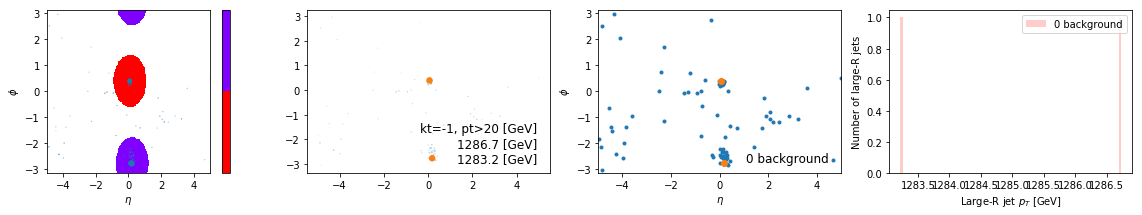

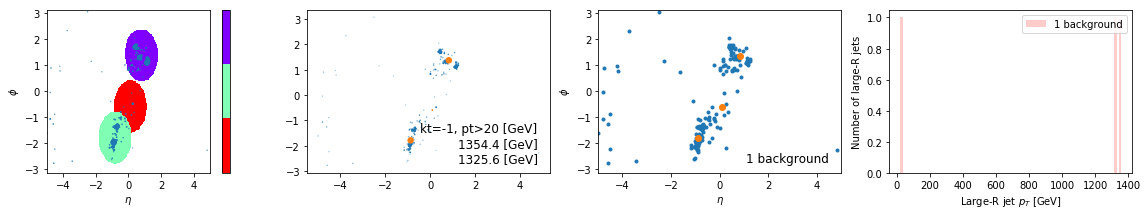

In [5]:
all_largeRjets, all_smallRjets, all_hadrons, all_largeRjets_ghost, all_smallRjets_ghost, all_hadrons_ghost \
    = reconstruction(fillGhost = True, plotArea = True)
# _, _, _, _, _, _ = reconstruction(kt=0)
# _, _, _, _, _, _ = reconstruction(kt=1)


# Store fastjet to HDF5
Signal and background tables are store in the same file<br>
- Columns: [pt_jet1, eta_jet1, phi_jet1, mass_jet1, pt_jet2, eta_jet2, phi_jet2, mass_jet2, pt_jet3, eta_jet3, phi_jet3, mass_jet3]<br>
- Rows: events

In [6]:
def saveJets(dataset, filename = 'LargeRjets.h5'):
    for mytype in ['background','signal']:
        data = {}
        kjet = 3
        for ijet in range(kjet):
            data['pt_jet'+str(ijet+1)]  = [dataset[mytype][ievt][ijet].pt  if ijet < len(all_largeRjets[mytype][ievt]) else 0. for ievt in range(len(all_largeRjets[mytype]))]
            data['eta_jet'+str(ijet+1)] = [dataset[mytype][ievt][ijet].eta if ijet < len(all_largeRjets[mytype][ievt]) else 0. for ievt in range(len(all_largeRjets[mytype]))]
            data['phi_jet'+str(ijet+1)] = [dataset[mytype][ievt][ijet].phi if ijet < len(all_largeRjets[mytype][ievt]) else 0. for ievt in range(len(all_largeRjets[mytype]))]
            data['mass_jet'+str(ijet+1)]= [dataset[mytype][ievt][ijet].mass if ijet < len(all_largeRjets[mytype][ievt]) else 0. for ievt in range(len(all_largeRjets[mytype]))]

        df = pd.DataFrame(data)
        savename = H5output + mytype + '_' + filename

        if df.empty:
            print('\x1b[31m[Warn.]\x1b[0m', savename, '\x1b[31mNOT\x1b[0m', 'created')
        else:
            df.to_hdf(savename, key=mytype, table=True, mode='a')
            print('\x1b[32m[Info.]\x1b[0m', savename, 'created')

saveJets(all_largeRjets)

[Info.] ../h5files/background_LargeRjets.h5 created
[Warn.] ../h5files/signal_LargeRjets.h5 NOT created


# Store hadrons to HDF5
One table per event<br>
- Name: mytype+ievt<br>
- Columns: hadron index<br>
- Rows: [pT, eta, phi, mass]

In [7]:
def saveHadrons(all_hadrons, filename = 'hadron.h5'):
    for mytype in ['background','signal']:
        savename = H5output + mytype + '_' + filename

        if len(all_hadrons[mytype]) == 0:
            print('\x1b[31m[Warn.]\x1b[0m', mytype, '\x1b[31mNOT\x1b[0m', 'saved to', savename)
        else:
            for ievt in range(len(all_hadrons[mytype])):
                df = pd.DataFrame(all_hadrons[mytype][ievt])
                df.to_hdf(savename, key=mytype+str(ievt), table=True, mode='a')
                print('\x1b[32m[Info.]\x1b[0m', mytype+str(ievt), 'save to', savename)

saveHadrons(all_hadrons, 'hadron.h5')
saveHadrons(all_hadrons_ghost, 'hadron_ghost.h5')


[Info.] background0 save to ../h5files/background_hadron.h5
[Info.] background1 save to ../h5files/background_hadron.h5
[Warn.] signal NOT saved to ../h5files/signal_hadron.h5
[Info.] background0 save to ../h5files/background_hadron_ghost.h5
[Info.] background1 save to ../h5files/background_hadron_ghost.h5
[Warn.] signal NOT saved to ../h5files/signal_hadron_ghost.h5


# Read fastjets from HDF5


In [8]:
def readJets(mytype, filename = 'LargeRjets.h5'):
    savename = H5output + mytype + '_' + filename
    if not os.path.exists(savename):
        return
    process = pd.read_hdf(savename, key=mytype)
    np.shape(process)
    yield process

# test
for process in readJets('signal'):
    print(process)

# Read hadons from HDF5
One table per event

In [9]:
def readHadrons(mytype, filename = 'hadron.h5'):
    savename = H5output + mytype + '_' + filename
    if not os.path.exists(savename):
        print('\x1b[31m[Warn.]\x1b[0m', savename, '\x1b[31mNOT\x1b[0m', 'found')
        return
    keys = []
    with h5py.File(savename, 'r') as f:
        keys = list(f)
    for key in keys:
        event = pd.read_hdf(savename, key=key)
        events_combined = event.T
        np.shape(events_combined)
        yield events_combined

# test
for event in readHadrons('background', filename = 'hadron_ghost.h5'):
    print('zhang')
    print(event)


zhang
              0             1         2             3             4     \
pT    1.000000e-08  1.000000e-08  1.110892  1.000000e-08  1.000000e-08   
eta   1.075000e+00  9.750000e-01  0.216245  3.250000e-01  6.250000e-01   
phi  -2.309071e+00 -2.151991e+00 -1.765521 -1.775000e+00  2.623230e+00   
mass -1.000000e+00 -1.000000e+00 -1.000000 -1.000000e+00 -1.000000e+00   

              5             6             7             8             9     \
pT    1.000000e-08  1.000000e-08  1.000000e-08  1.000000e-08  1.000000e-08   
eta   6.250000e-01 -6.250000e-01 -6.250000e-01  1.125000e+00 -7.750000e-01   
phi  -1.869248e+00  2.937389e+00 -2.183407e+00 -3.094469e+00 -3.031637e+00   
mass -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   

         ...          4053       4054       4055       4056      4057  \
pT       ...      6.559511  17.240501  84.998764  19.044254  8.700417   
eta      ...      0.052834   0.048972   0.045796   0.048623  0.068490   
phi      ... 

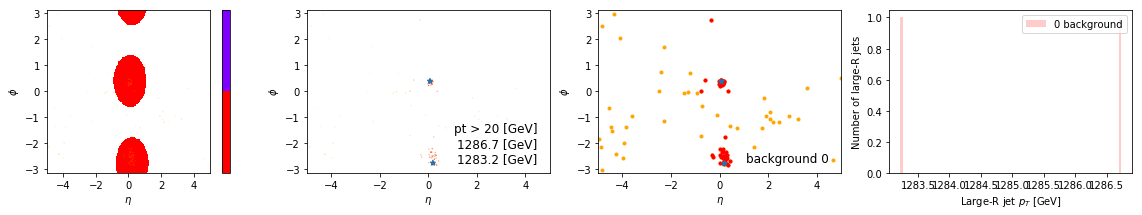

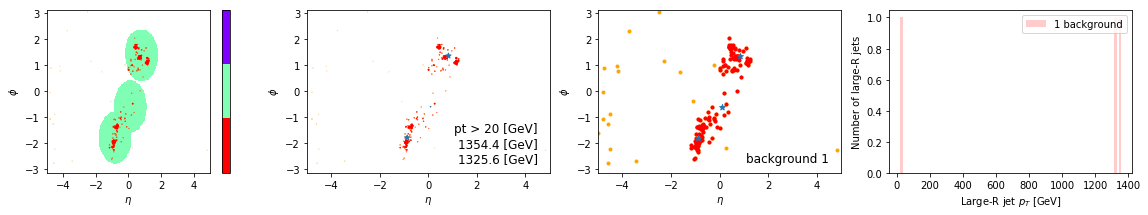

In [19]:
def plot_jet_area(largeRjets, hadrons, hadrons_ghosts):

    jets = largeRjets.tolist()
    fig = plt.figure(figsize=(20, 3))

    # define eta and phi ranges and number of bins along each axis
    eta_min, eta_max = -5., 5.
    extent = eta_min, eta_max, -np.pi, np.pi
    bins = 200

    ax = fig.add_subplot(1, 4, 1)
    eta_edges = np.linspace(eta_min, eta_max, bins + 1)
    phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
    area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1), dtype=np.float64)
    for ijet, jet in enumerate(hadrons_ghosts):
        jetarea, _, _ = np.histogram2d(hadrons_ghosts['eta'], hadrons_ghosts['phi'], bins=(eta_edges, phi_edges))
        area += (jetarea > 0) * (ijet + 1)

    # pick a different color for each jet
    colors = cm.rainbow(np.linspace(0, 1, int(len(largeRjets)/4)))
    cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
    # plot all areas
    plt.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
              extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
              interpolation='none', origin='lower')
    cbar = plt.colorbar()
    cbar.ax.invert_yaxis()

    # overlay original hadron
    hadrons_injets = hadrons_ghosts[hadrons_ghosts['pT'] > 0.0000001]

    plt.scatter(hadrons['eta'], hadrons['phi'], s=30 * hadrons['pT'] / hadrons['pT'].max(), c='orange', marker='.')
    plt.scatter(hadrons_injets['eta'], hadrons_injets['phi'], s=30 * hadrons_injets['pT'] / hadrons_injets['pT'].max(), c='red', marker='.')

    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    plt.xlabel(r'$\eta$')
    plt.ylabel(r'$\phi$')

    # plot positions
    jets_pt = largeRjets.filter(like='pt_jet', axis=0).values
    jets_eta = largeRjets.filter(like='eta_jet', axis=0).values
    jets_phi = largeRjets.filter(like='phi_jet', axis=0).values
    jets_mass = largeRjets.filter(like='mass_jet', axis=0).values
    
    ax = fig.add_subplot(1, 4, 2)
    plt.scatter(x=hadrons['eta'], y=hadrons['phi'], s=30 * hadrons['pT'] / hadrons['pT'].max(), c='orange', marker='.')
    plt.scatter(hadrons_injets['eta'], hadrons_injets['phi'], s=30 * hadrons_injets['pT'] / hadrons_injets['pT'].max(), c='red', marker='.')
    plt.scatter(x=jets_eta, y=jets_phi, s=30 * jets_pt / jets_pt.max(), marker='*')

    ax.text(0.95, 0.05, 'pt > 20 [GeV]'+'\n{:.1f} [GeV]\n{:.1f} [GeV]'.format(jets_pt[0],jets_pt[1]),
        verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=12)
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    plt.xlabel(r'$\eta$')
    plt.ylabel(r'$\phi$')
    ax = fig.add_subplot(1, 4, 3)
    plt.scatter(x=hadrons['eta'], y=hadrons['phi'], c='orange', marker='.')
    plt.scatter(hadrons_injets['eta'], hadrons_injets['phi'], c='red', marker='.')
    plt.scatter(x=jets_eta, y=jets_phi, marker='*')
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    plt.xlabel(r'$\eta$')
    plt.ylabel(r'$\phi$')
    ax.text(0.95, 0.05, mytype+' '+str(ievt),
        verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=12)

    ax = fig.add_subplot(1, 4, 4)
    plt.hist(jets_pt, bins=100, facecolor='r', alpha=0.2, label=str(ievt)+' '+mytype)
    plt.xlabel(r'Large-R jet $p_{T}$ [GeV]')
    plt.ylabel('Number of large-R jets')
    plt.legend(loc='upper right')

for mytype in ['background']:
    hadrons = readHadrons(mytype = mytype)
    hadron_ghosts = readHadrons(mytype = mytype, filename = 'hadron_ghost.h5')
    processes = readJets(mytype = mytype)

    try:
        jets_allevent         = next(processes)
    except StopIteration:
        continue
    
    for ievt, jets_perevent in jets_allevent.head(n=2).iterrows():
        try:
            hadron_perevent       = next(hadrons)
            hadron_ghost_perevent = next(hadron_ghosts)
        except StopIteration:
            continue
    
        hadron_perevent = hadron_perevent.T
        hadron_ghost_perevent = hadron_ghost_perevent.T
        jets_perevent = jets_perevent.iloc[jets_perevent.nonzero()[0]]
        plot_jet_area(jets_perevent, hadron_perevent, hadron_ghost_perevent)

# for ievt in range(len(all_largeRjets_ghost[mytype])):
#     plot_jet_area(all_hadrons_ghost = all_hadrons_ghost, all_largeRjets_ghost = all_largeRjets_ghost, mytype = mytype, ievt = ievt)


In [13]:
# test
for event in readHadrons('background'):
    print(event)

           0         1         2         3         4         5         6    \
pT    0.324101  0.409859  0.867922  0.383031  2.308583  2.710120  1.651875   
eta  -0.361158 -2.429939 -2.267777 -1.204714 -1.316314 -0.929923 -0.754817   
phi   2.737669  0.729830 -1.161310  0.692571 -0.029902 -0.062794 -1.705690   
mass  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           7         8         9      ...          99        100       101  \
pT    1.011992  0.972791  1.243262    ...     1.383620  4.321024  3.587547   
eta  -0.754993 -0.609129 -0.306729    ...     0.141394  0.156435  0.164799   
phi   0.000512  0.431733 -2.451038    ...    -2.503586  0.266360 -2.773004   
mass  0.000000  0.000000  0.000000    ...     0.000000  0.000000  0.000000   

            102       103       104       105       106       107       108  
pT    11.134822  2.330862  2.163052  3.354795  1.830593  0.537007  0.544174  
eta    0.170725  0.188516  0.310066  0.339082  0.709571  2.449

# Replot jet area from memory

In [ ]:
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

plotGhost = True
plotPosition = True

def plot_jet_area(all_hadrons_ghost = all_hadrons_ghost, all_largeRjets_ghost = all_largeRjets_ghost, mytype = 'background', ievt = 0):
    fig = plt.figure(figsize=(20, 3))

    if plotGhost:
        # define eta and phi ranges and number of bins along each axis
        eta_min, eta_max = -5., 5.
        extent = eta_min, eta_max, -np.pi, np.pi
        bins = 200
        event = all_largeRjets_ghost[mytype][ievt]
        # pick a different color for each jet
        colors = cm.rainbow(np.linspace(0, 1, len(event)))
        cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
        ax = fig.add_subplot(1, 4, 1)
        eta_edges = np.linspace(eta_min, eta_max, bins + 1)
        phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
        area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1), dtype=np.float64)
        for ijet, jet in enumerate(event):
            constit = jet.constituents_array()
            jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'], bins=(eta_edges, phi_edges))
            area += (jetarea > 0) * (ijet + 1)

        # plot all areas
        plt.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
                  extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
                  interpolation='none', origin='lower')
        cbar = plt.colorbar()
        cbar.ax.invert_yaxis()
        
        # overlay original event
        particles = all_hadrons_ghost[mytype][ievt]
        print('particles', len(particles), particles)
        ax.scatter(particles['eta'], particles['phi'], s=30 * particles['pT'] / particles['pT'].max())

        ax.set_xlim(extent[:2])
        ax.set_ylim(extent[2:])
        plt.xlabel(r'$\eta$')
        plt.ylabel(r'$\phi$')

    if plotPosition:
        jets_eta = [all_largeRjets[mytype][ievt][ijet].eta for ijet in range(len(all_largeRjets[mytype][ievt]))]
        jets_phi = [all_largeRjets[mytype][ievt][ijet].phi for ijet in range(len(all_largeRjets[mytype][ievt]))]
        jets_pt = np.array([all_largeRjets[mytype][ievt][ijet].pt for ijet in range(len(all_largeRjets[mytype][ievt]))])
        ax = fig.add_subplot(1, 4, 2)
        plt.scatter(x=all_hadrons[mytype][ievt]['eta'], y=all_hadrons[mytype][ievt]['phi'], s=30 * all_hadrons[mytype][ievt]['pT'] / all_hadrons[mytype][ievt]['pT'].max(), marker='.')
        plt.scatter(x=jets_eta, y=jets_phi, s=30 * jets_pt/max(jets_pt), marker='o')
        ax.text(0.95, 0.05, 'pt > 20 [GeV]'+'\n{:.1f} [GeV]\n{:.1f} [GeV]'.format(jets_pt[0],jets_pt[1]),
            verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=12)
        ax = fig.add_subplot(1, 4, 3)
        plt.scatter(x=all_hadrons[mytype][ievt]['eta'], y=all_hadrons[mytype][ievt]['phi'], marker='.')
        plt.scatter(x=jets_eta, y=jets_phi, marker='o')
        ax.set_xlim(extent[:2])
        ax.set_ylim(extent[2:])
        plt.xlabel(r'$\eta$')
        plt.ylabel(r'$\phi$')
        ax.text(0.95, 0.05, mytype+' '+str(ievt),
            verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=12)
        
        ax = fig.add_subplot(1, 4, 4)
        plt.hist(jets_pt, bins=100, facecolor='r', alpha=0.2, label=str(ievt)+' '+mytype)
        plt.xlabel(r'Large-R jet $p_{T}$ [GeV]')
        plt.ylabel('Number of large-R jets')
        plt.legend(loc='upper right')
    
for mytype in ['background','signal']:
    for ievt in range(len(all_largeRjets_ghost[mytype])):
        plot_jet_area(all_hadrons_ghost = all_hadrons_ghost, all_largeRjets_ghost = all_largeRjets_ghost, mytype = mytype, ievt = ievt)


In [ ]:
def getJet(alljets, index):
    jet = {}
    for mytype in ['background','signal']:
        jet[mytype]={'pt':[], 'eta':[], 'phi':[]}
        for ievt in range(len(all_largeRjets[mytype])):
            jet[mytype]['pt'] += [alljets[mytype][ievt][index].pt]
            jet[mytype]['eta'] += [alljets[mytype][ievt][index].eta]
            jet[mytype]['phi'] += [alljets[mytype][ievt][index].phi]
    return jet

lead_largeRjets, sublead_largeRjets = getJet(all_largeRjets, 0), getJet(all_largeRjets, 1)
lead_smallRjets, sublead_smallRjets = getJet(all_smallRjets, 0), getJet(all_smallRjets, 1)
print(len(lead_largeRjets), lead_largeRjets, lead_largeRjets['background'])

In [ ]:
#Let's make some very simple plots.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(lead_largeRjets['background']['pt'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(lead_largeRjets['signal']['pt'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'Leading jet $p_{T}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.savefig("leadjetpt.pdf")

In [ ]:
mjj={}
for mytype in ['background','signal']:
    mjj[mytype]=[]
    for k in range(len(all_largeRjets[mytype])):
        E = all_largeRjets[mytype][k][0].e+all_largeRjets[mytype][k][1].e
        px = all_largeRjets[mytype][k][0].px+all_largeRjets[mytype][k][1].px
        py = all_largeRjets[mytype][k][0].py+all_largeRjets[mytype][k][1].py
        pz = all_largeRjets[mytype][k][0].pz+all_largeRjets[mytype][k][1].pz
        mjj[mytype]+=[(E**2-px**2-py**2-pz**2)**0.5]


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(mjj['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(mjj['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.savefig("mjj.pdf")

# TODO
store jets to h5 file for later ML code
k-means?